## Machine Learning Challenge – Using AI to Validate Carbon Containment in the Illinois Basin 
### Date: Apr 2023

Problem Statement

This challenge aims to use time series injection information and monitoring data on a carbon capture well to predict carbon capture well injection rates deltas. Correlating the change in injection rate to the behavior of other parameters in the well can be used to provide a checkpoint against carbon migration from the well or other losses during the process. The code developed to predict injection rate deltas based on monitoring well data can be used to validate carbon containment throughout the injection of the well.

In [31]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os.path


import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler

### Load Data

In [32]:
#set directory for csv files
dir_name = r'C:\Users\vasan\OneDrive - California Resources Corporation\01_Admin\07_MLChallenge'
filename_suffix = 'csv'

In [33]:
#read file
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
dftrain = pd.read_csv("illinois_basing_train_04112023.csv", thousands=',', skiprows = skiprows)
dftrain.head()

SampleTimeUTC  Avg_PLT_CO2VentRate_TPH  Avg_CCS1_WHCO2InjPs_psi  \
0  10/1/2009 0:00                20.543221                 1.880208   
1  10/1/2009 1:00                20.543221                 1.374349   
2  10/1/2009 2:00                20.543221                 1.315104   
3  10/1/2009 3:00                20.543221                 1.255859   
4  10/1/2009 4:00                20.543221                 1.342448   

   Avg_CCS1_WHCO2InjTp_F  Avg_CCS1_ANPs_psi  Avg_CCS1_DH6325Ps_psi  \
0              59.400879          89.967778            2893.787960   
1              55.654541          89.825334            2893.793620   
2              53.661254          89.806754            2893.791506   
3              52.319824          89.806754            2893.786399   
4              48.994263          89.610633            2893.774135   

   Avg_CCS1_DH6325Tp_F  Avg_VW1_WBTbgPs_psi  Avg_VW1_WBTbgTp_F  \
0           116.539694          2173.710958         104.061007   
1           116.538811          2173.762679         104.049292   
2           116.538623          2173.754085         104.050357   
3           116.537392          2173.734355         104.051422   
4           116.537714          2173.738489         104.051422   

   Avg_VW1_ANPs_psi  ...  Avg_VW1_Z04D6837Tp_F  Avg_VW1_Z03D6945Ps_psi  \
0       1599.975952  ...            120.209798             3164.194175   
1       1599.975952  ...            120.211298             3164.154578   
2       1599.975952  ...            120.204548             3164.142426   
3       1599.975952  ...            120.209048             3164.138940   
4       1599.975952  ...            120.206798             3164.143589   

   Avg_VW1_Z03D6945Tp_F  Avg_VW1_Z02D6982Ps_psi  Avg_VW1_Z02D6982Tp_F  \
0            121.361094             3184.043494            121.462733   
1            121.360299             3184.060020            121.461173   
2            121.352469             3184.060055            121.468179   
3            121.352378             3184.031604            121.476759   
4            121.346063             3184.019531            121.474419   

   Avg_VW1_Z01D7061Ps_psi  Avg_VW1_Z01D7061Tp_F  Avg_VW1_Z0910D5482Ps_psi  \
0             3216.464494            120.278862               2441.864587   
1             3216.520127            120.276792               2442.006201   
2             3216.510374            120.280932               2442.070968   
3             3216.479380            120.300598               2442.143066   
4             3216.436283            120.307843               2442.282528   

   Avg_VW1_Z0910D5482Tp_F  inj_diff   
0              111.881138        NaN  
1              111.891938        0.0  
2              111.891218        0.0  
3              111.899858        0.0  
4              111.909219        0.0  

[5 rows x 35 columns]

### Data Cleaning

In [34]:
dftrain.shape

(27398, 35)

In [35]:
dftrain.describe()

Avg_PLT_CO2VentRate_TPH  Avg_CCS1_WHCO2InjPs_psi  \
count             27398.000000             27270.000000   
mean                  2.122022              1239.861825   
std                 133.162146               817.740091   
min                   0.000000                 0.000000   
25%                   0.000000              1235.469308   
50%                   0.058333              1338.872024   
75%                   0.150000              1361.045834   
max               18333.150000             39032.410160   

       Avg_CCS1_WHCO2InjTp_F  Avg_CCS1_ANPs_psi  Avg_CCS1_DH6325Ps_psi  \
count           27398.000000       27304.000000           27398.000000   
mean               89.766221         560.862134            3244.168246   
std                48.287324         445.931405             173.471253   
min                 0.000000           0.000000               0.000000   
25%                92.953925         523.536663            3233.023426   
50%                96.268226         564.901591            3286.067870   
75%                96.851236         604.763645            3324.735273   
max              2879.416016       24105.630860            3515.880615   

       Avg_CCS1_DH6325Tp_F  Avg_VW1_WBTbgPs_psi  Avg_VW1_WBTbgTp_F  \
count         27398.000000         26127.000000       26061.000000   
mean            127.738740          1801.844864          80.794406   
std               7.167508           999.374082          44.286916   
min               0.000000             0.000000           0.000000   
25%             127.166621          2173.526853         103.423346   
50%             130.109008          2322.382139         104.196940   
75%             131.082033          2379.839354         105.044018   
max             135.670399          4954.731745         120.056561   

       Avg_VW1_ANPs_psi  Avg_VW1_Z11D4917Ps_psi  ...  Avg_VW1_Z04D6837Tp_F  \
count      23487.000000            26688.000000  ...          26600.000000   
mean         525.000311             1597.476442  ...             90.967574   
std         3988.707539              873.254402  ...             51.589928   
min            0.000000                0.000000  ...              0.000000   
25%            0.452148             2070.333608  ...            118.813235   
50%            4.656250             2073.364497  ...            119.543503   
75%           16.900514             2074.094025  ...            119.852003   
max        31993.509770             2377.999424  ...            125.766369   

       Avg_VW1_Z03D6945Ps_psi  Avg_VW1_Z03D6945Tp_F  Avg_VW1_Z02D6982Ps_psi  \
count            24361.000000          25932.000000            26423.000000   
mean              2350.941782            182.281703             2456.608853   
std               1495.701897            368.506491             1459.143450   
min                  0.000000              0.000000                0.000000   
25%                  0.000000              0.000000                0.000000   
50%               3299.938442            121.297661             3316.204091   
75%               3320.609979            122.832244             3332.014610   
max               3457.878882           1602.857486             3499.615312   

       Avg_VW1_Z02D6982Tp_F  Avg_VW1_Z01D7061Ps_psi  Avg_VW1_Z01D7061Tp_F  \
count          26423.000000            25307.000000          25108.000000   
mean              91.272574             2300.195377             85.859433   
std               52.699934             1521.416947             55.366988   
min                0.000000                0.000000              0.000000   
25%               32.002941                0.000000              0.000000   
50%              121.263339             3318.194554            121.362099   
75%              122.027798             3327.320356            122.551008   
max              124.310501             3445.065566            133.912303   

       Avg_VW1_Z0910D5482Ps_psi  Avg_VW1_Z0910D5482Tp_F     inj_diff

In [36]:
dftrain.dtypes

SampleTimeUTC                object
Avg_PLT_CO2VentRate_TPH     float64
Avg_CCS1_WHCO2InjPs_psi     float64
Avg_CCS1_WHCO2InjTp_F       float64
Avg_CCS1_ANPs_psi           float64
Avg_CCS1_DH6325Ps_psi       float64
Avg_CCS1_DH6325Tp_F         float64
Avg_VW1_WBTbgPs_psi         float64
Avg_VW1_WBTbgTp_F           float64
Avg_VW1_ANPs_psi            float64
Avg_VW1_Z11D4917Ps_psi      float64
Avg_VW1_Z11D4917Tp_F        float64
Avg_VW1_Z10D5001Ps_psi      float64
Avg_VW1_Z10D5001Tp_F        float64
Avg_VW1_Z09D5653Ps_psi      float64
Avg_VW1_Z09D5653Tp_F        float64
Avg_VW1_Z08D5840Ps_psi      float64
Avg_VW1_Z08D5840Tp_F        float64
Avg_VW1_Z07D6416Ps_psi      float64
Avg_VW1_Z07D6416Tp_F        float64
Avg_VW1_Z06D6632Ps_psi      float64
Avg_VW1_Z06D6632Tp_F        float64
Avg_VW1_Z05D6720Ps_psi      float64
Avg_VW1_Z05D6720Tp_F        float64
Avg_VW1_Z04D6837Ps_psi      float64
Avg_VW1_Z04D6837Tp_F        float64
Avg_VW1_Z03D6945Ps_psi      float64
Avg_VW1_Z03D6945Tp_F        

In [37]:
#convert time column to datetime format
#dftrain['SampleTimeUTC'] = pd.to_datetime(dftrain['SampleTimeUTC'])

In [38]:
# convert the date column to datetime format and set it as the index
dftrain.set_index(pd.to_datetime(dftrain['SampleTimeUTC']), inplace=True)

# drop the original date column
dftrain.drop('SampleTimeUTC', axis=1, inplace=True)

In [39]:
dftrain['inj_diff ']

SampleTimeUTC
2009-10-01 00:00:00         NaN
2009-10-01 01:00:00    0.000000
2009-10-01 02:00:00    0.000000
2009-10-01 03:00:00    0.000000
2009-10-01 04:00:00    0.000000
                         ...   
2012-11-18 03:00:00   -0.031250
2012-11-18 04:00:00   -0.091320
2012-11-18 05:00:00   -0.137501
2012-11-18 06:00:00    0.037290
2012-11-18 07:00:00   -0.080345
Name: inj_diff , Length: 27398, dtype: float64

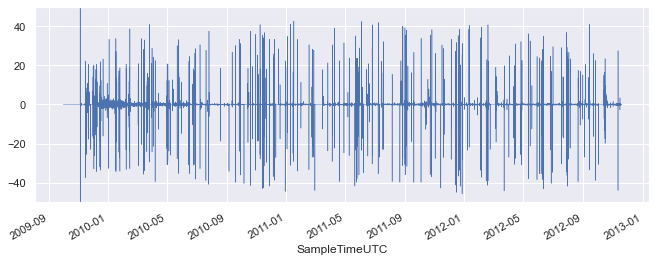

In [40]:
sns.set(rc={'figure.figsize':(11, 4)})
ax = dftrain['inj_diff '].plot(linewidth=0.5)
ax.set_ylim(-50, 50)
plt.show()

C:\Users\vasan\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


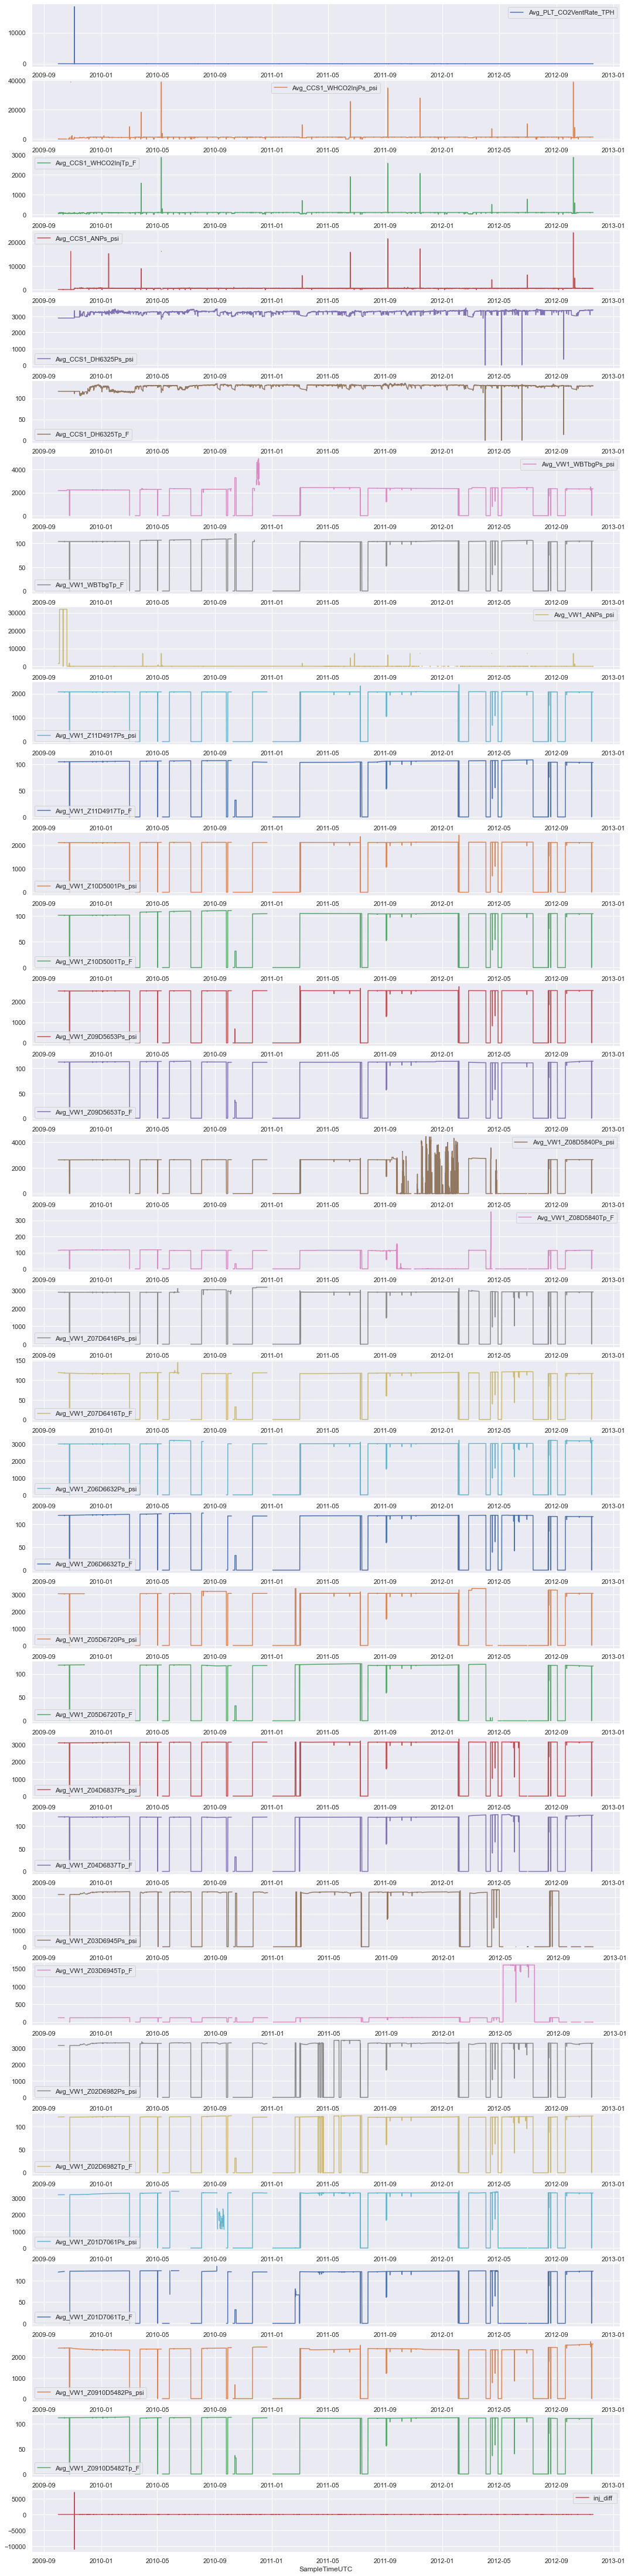

In [41]:
# create a plot with increased size
fig, ax = plt.subplots(figsize=(18, 80))
dftrain.plot(ax=ax, subplots=True)


# show the plot
plt.show()

array([[<AxesSubplot:title={'center':'Avg_PLT_CO2VentRate_TPH'}>,
        <AxesSubplot:title={'center':'Avg_CCS1_WHCO2InjPs_psi'}>,
        <AxesSubplot:title={'center':'Avg_CCS1_WHCO2InjTp_F'}>,
        <AxesSubplot:title={'center':'Avg_CCS1_ANPs_psi'}>,
        <AxesSubplot:title={'center':'Avg_CCS1_DH6325Ps_psi'}>,
        <AxesSubplot:title={'center':'Avg_CCS1_DH6325Tp_F'}>],
       [<AxesSubplot:title={'center':'Avg_VW1_WBTbgPs_psi'}>,
        <AxesSubplot:title={'center':'Avg_VW1_WBTbgTp_F'}>,
        <AxesSubplot:title={'center':'Avg_VW1_ANPs_psi'}>,
        <AxesSubplot:title={'center':'Avg_VW1_Z11D4917Ps_psi'}>,
        <AxesSubplot:title={'center':'Avg_VW1_Z11D4917Tp_F'}>,
        <AxesSubplot:title={'center':'Avg_VW1_Z10D5001Ps_psi'}>],
       [<AxesSubplot:title={'center':'Avg_VW1_Z10D5001Tp_F'}>,
        <AxesSubplot:title={'center':'Avg_VW1_Z09D5653Ps_psi'}>,
        <AxesSubplot:title={'center':'Avg_VW1_Z09D5653Tp_F'}>,
        <AxesSubplot:title={'center':'Avg_VW1_Z08D5

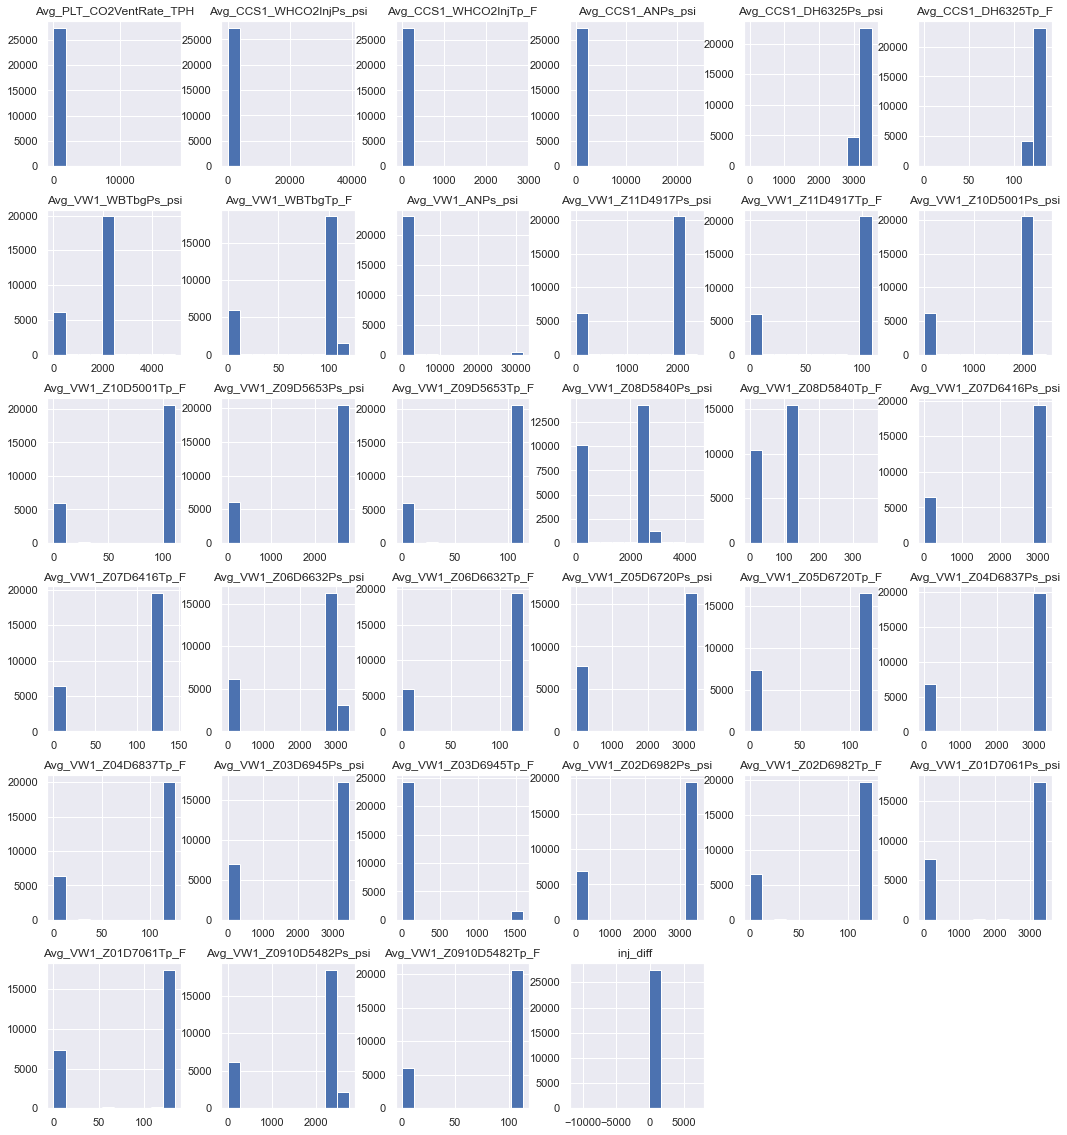

In [42]:
dftrain.hist(figsize=(18, 20))

C:\Users\vasan\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


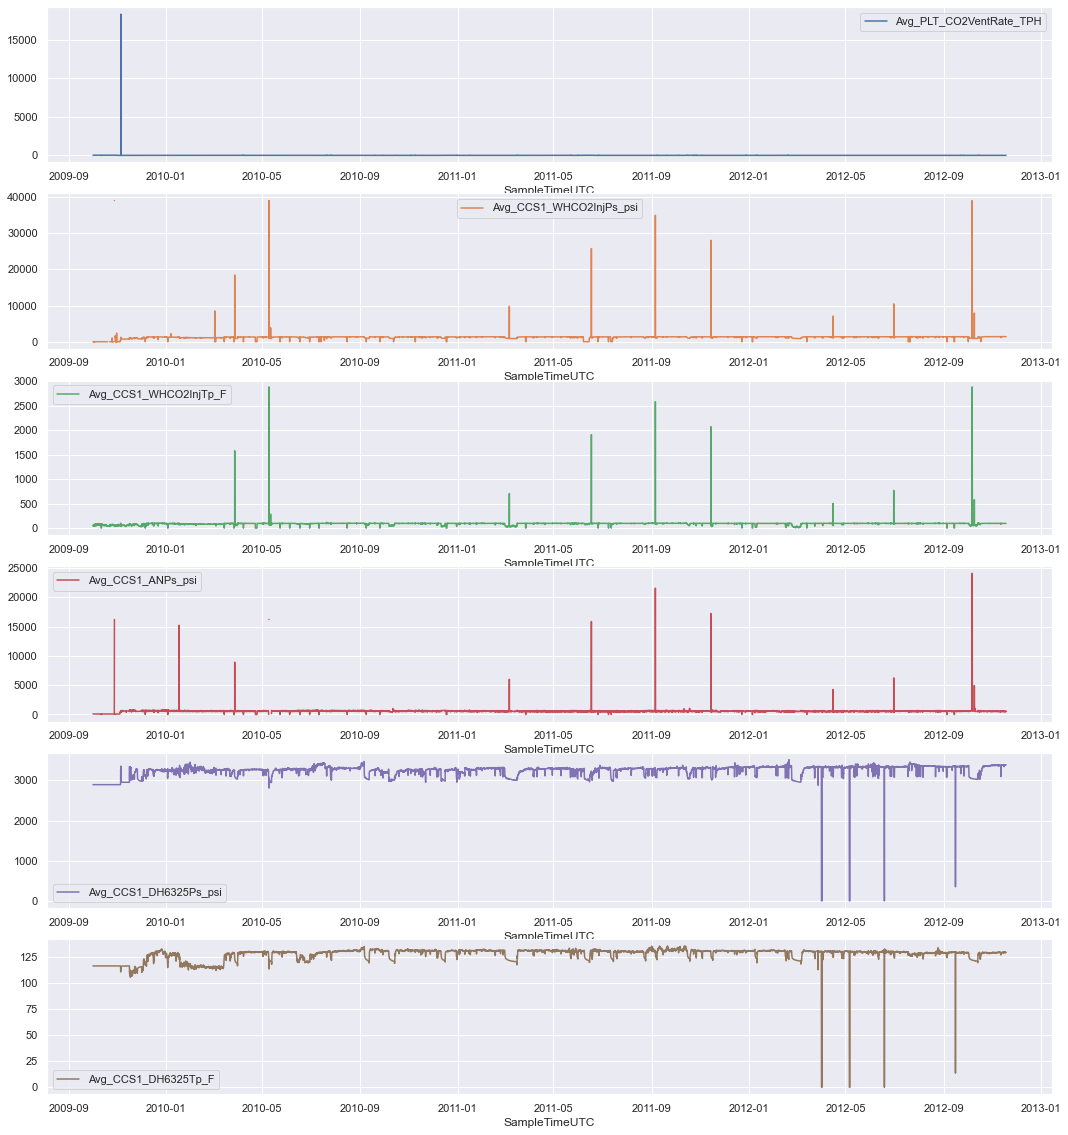

In [43]:
# create a plot with increased size
fig, ax = plt.subplots(figsize=(18, 20))
dftrain.iloc[:, 0:6].plot(ax=ax, subplots=True)


# show the plot
plt.show()

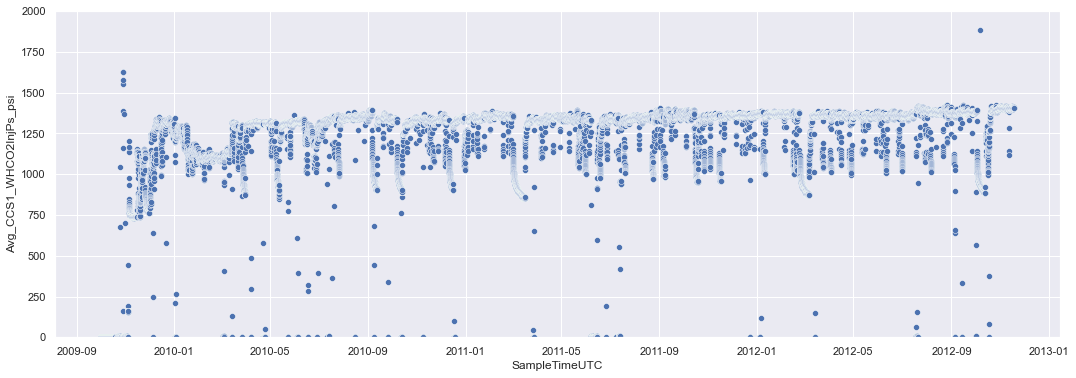

In [44]:
# set the figure size
sns.set(rc={'figure.figsize':(18, 6)})
# create a scatter plot with dots
sns.scatterplot(data=dftrain, x= dftrain.index, y='Avg_CCS1_WHCO2InjPs_psi')
# set the y-axis limit
plt.ylim(0, 2000)
# show the plot
plt.show()

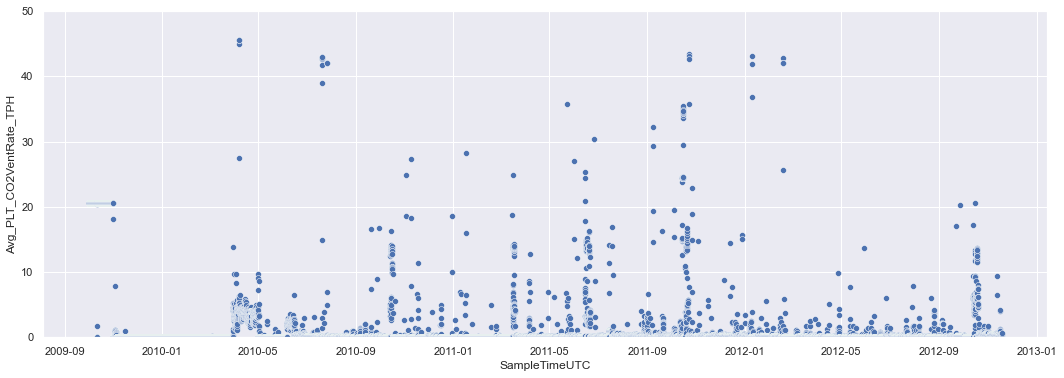

In [45]:
# set the figure size
sns.set(rc={'figure.figsize':(18, 6)})
# create a scatter plot with dots
sns.scatterplot(data=dftrain, x= dftrain.index, y='Avg_PLT_CO2VentRate_TPH')
# set the y-axis limit
plt.ylim(0, 50)
# show the plot
plt.show()


In [46]:
# drop rows with values greater than 1500 in column 'Avg_CCS1_WHCO2InjPs_psi'
dftrain = dftrain[dftrain['Avg_CCS1_WHCO2InjPs_psi'] <= 1500]

In [47]:
# drop rows with values lesser than 750 in column 'Avg_CCS1_WHCO2InjPs_psi'
dftrain = dftrain[dftrain['Avg_CCS1_WHCO2InjPs_psi'] >= 750]

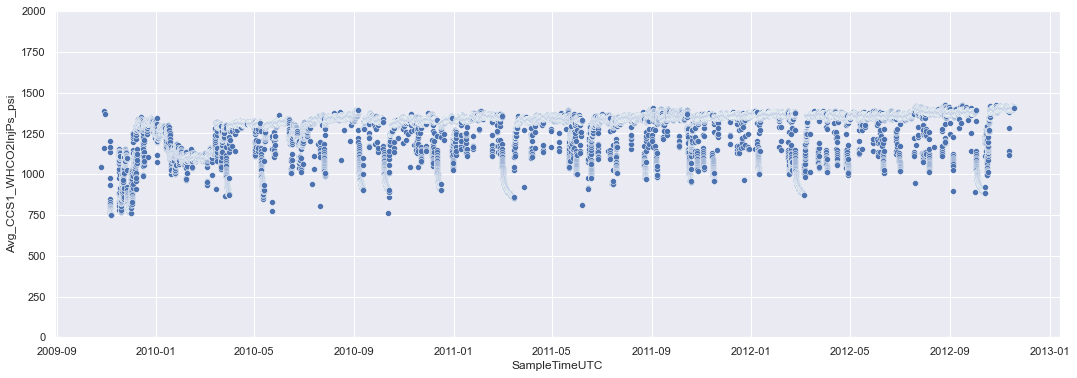

In [48]:
# set the figure size
sns.set(rc={'figure.figsize':(18, 6)})
# create a scatter plot with dots
sns.scatterplot(data=dftrain, x= dftrain.index, y='Avg_CCS1_WHCO2InjPs_psi')
# set the y-axis limit
plt.ylim(0, 2000)
# show the plot
plt.show()

In [49]:
dftrain.shape

(25733, 34)

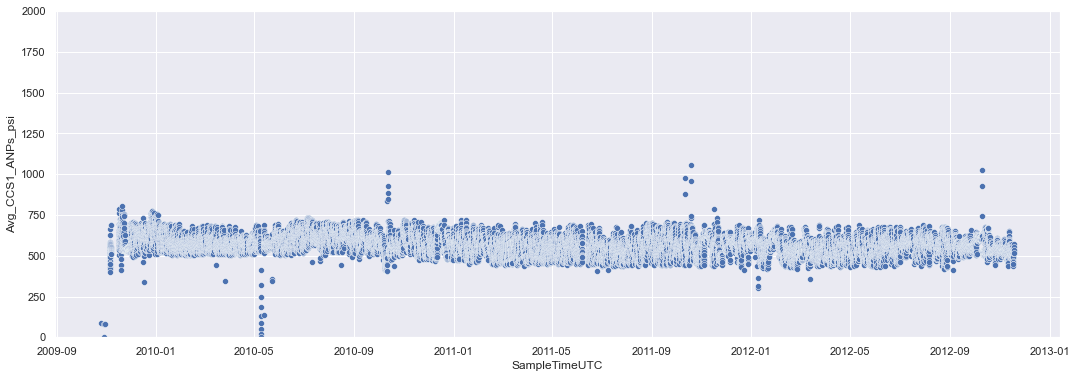

In [50]:
# set the figure size
sns.set(rc={'figure.figsize':(18, 6)})
# create a scatter plot with dots
sns.scatterplot(data=dftrain, x= dftrain.index, y='Avg_CCS1_ANPs_psi')
# set the y-axis limit
plt.ylim(0, 2000)
# show the plot
plt.show()

In [51]:
# drop rows with values greater than 750 in column 'Avg_CCS1_ANPs_psi'
dftrain = dftrain[dftrain['Avg_CCS1_ANPs_psi'] <= 750]

# drop rows with values lesser than 250 in column 'Avg_CCS1_ANPs_psi'
dftrain = dftrain[dftrain['Avg_CCS1_ANPs_psi'] >= 250]

In [52]:
dftrain.shape

(25607, 34)

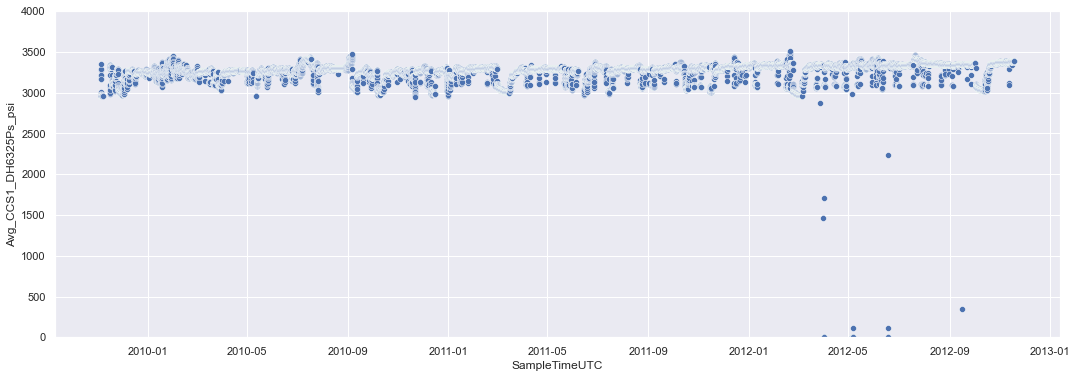

In [53]:
# set the figure size
sns.set(rc={'figure.figsize':(18, 6)})
# create a scatter plot with dots
sns.scatterplot(data=dftrain, x= dftrain.index, y='Avg_CCS1_DH6325Ps_psi')
# set the y-axis limit
plt.ylim(0, 4000)
# show the plot
plt.show()

In [54]:
# drop rows with values greater than 750 in column 'Avg_CCS1_ANPs_psi'
dftrain = dftrain[dftrain['Avg_CCS1_DH6325Ps_psi'] >= 2500]

In [55]:
dftrain.shape

(25562, 34)

C:\Users\vasan\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


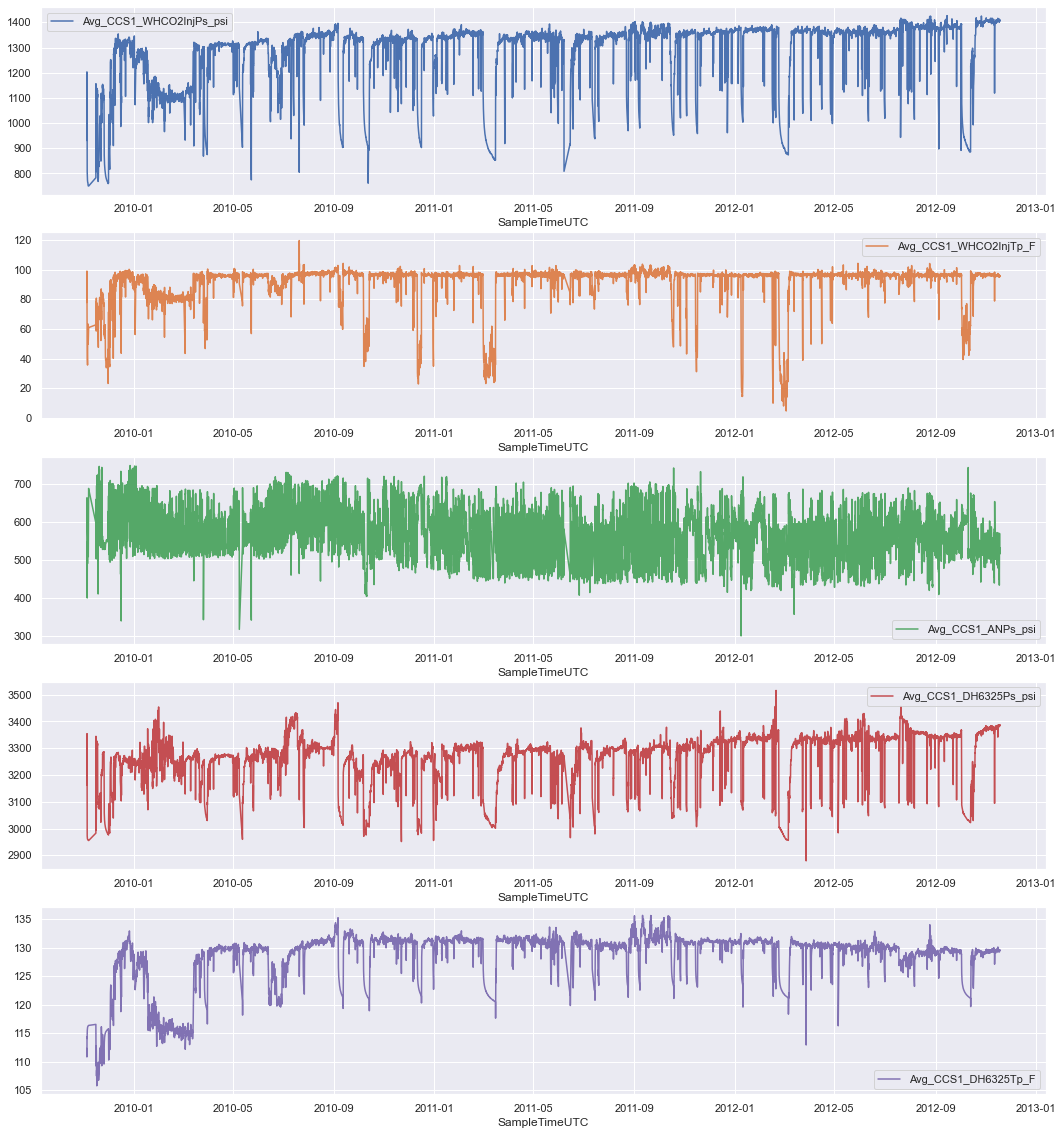

In [56]:
# create a plot with increased size
fig, ax = plt.subplots(figsize=(18, 20))
dftrain.iloc[:, 1:6].plot(ax=ax, subplots=True)


# show the plot
plt.show()

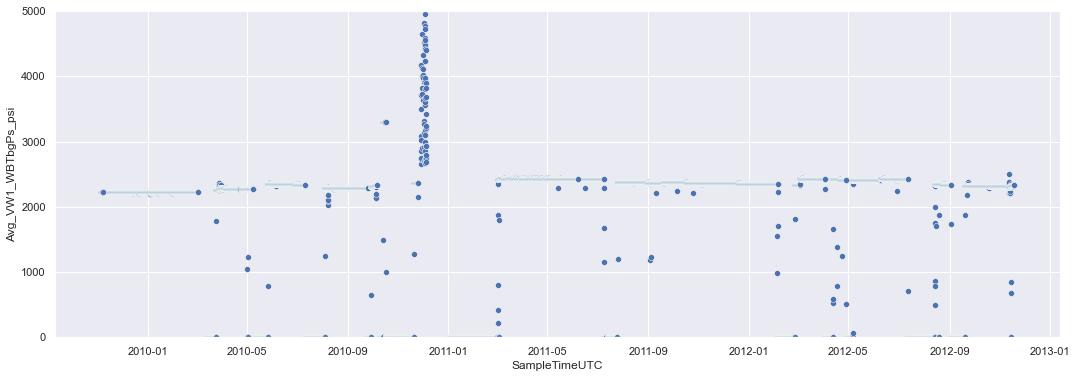

In [57]:
# set the figure size
sns.set(rc={'figure.figsize':(18, 6)})
# create a scatter plot with dots
sns.scatterplot(data=dftrain, x= dftrain.index, y='Avg_VW1_WBTbgPs_psi')
# set the y-axis limit
plt.ylim(0, 5000)
# show the plot
plt.show()

In [58]:
# drop rows with values greater than 2500 in column 'Avg_VW1_WBTbgPs_psi'
dftrain = dftrain[dftrain['Avg_VW1_WBTbgPs_psi'] <= 2500]

# drop rows with values lesser than 1500 in column 'Avg_VW1_WBTbgPs_psi'
dftrain = dftrain[dftrain['Avg_VW1_WBTbgPs_psi'] >= 1500]

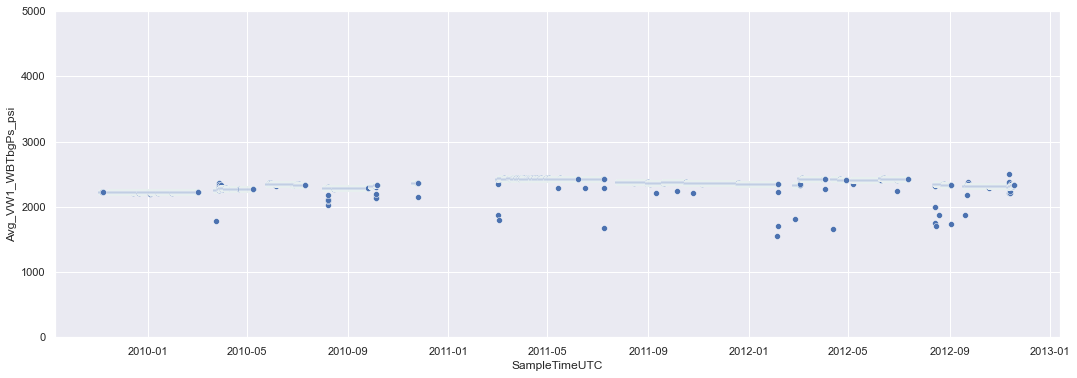

In [59]:
# set the figure size
sns.set(rc={'figure.figsize':(18, 6)})
# create a scatter plot with dots
sns.scatterplot(data=dftrain, x= dftrain.index, y='Avg_VW1_WBTbgPs_psi')
# set the y-axis limit
plt.ylim(0, 5000)
# show the plot
plt.show()

In [60]:
dftrain.shape

(18401, 34)

C:\Users\vasan\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


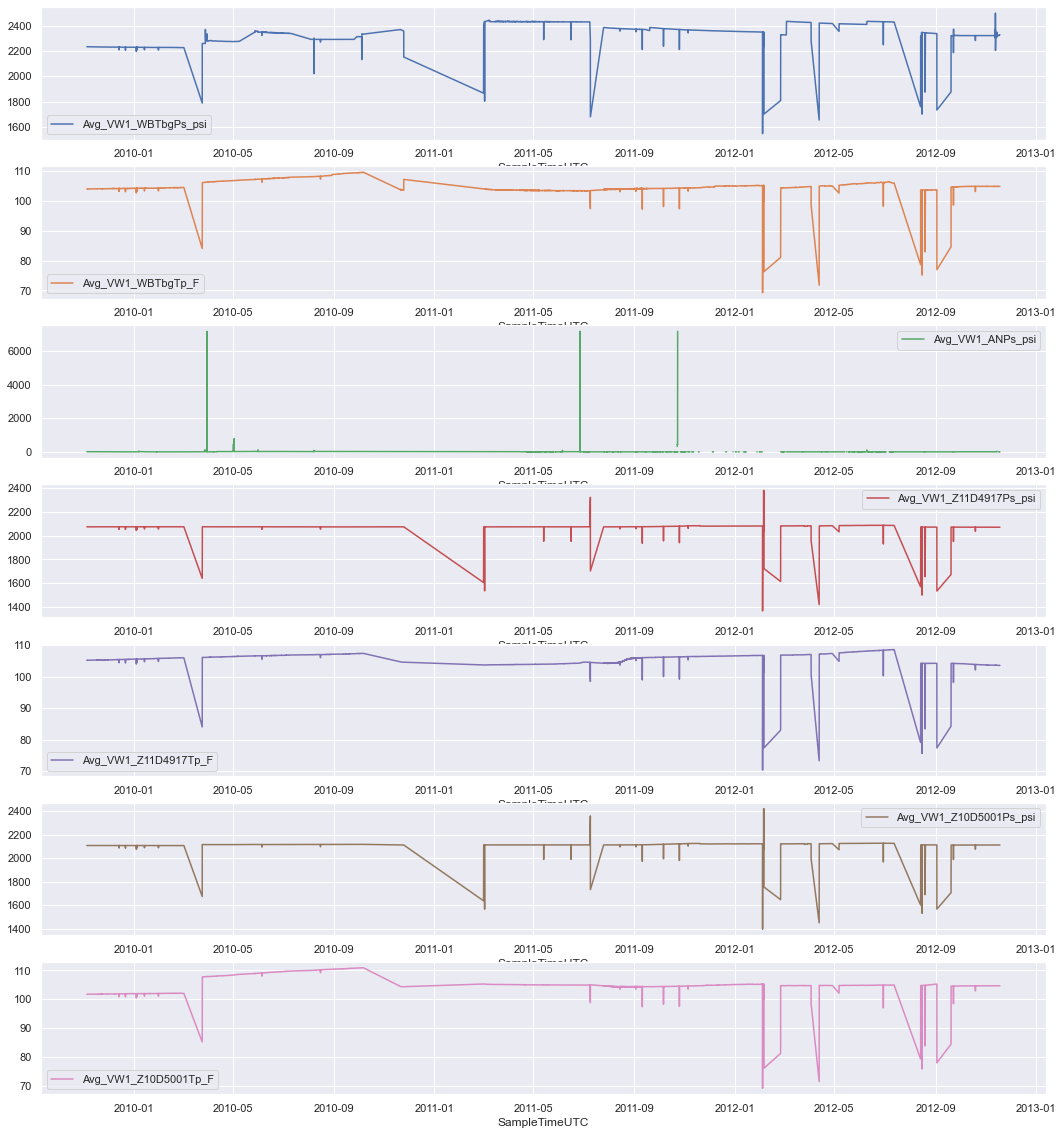

In [61]:
# create a plot with increased size
fig, ax = plt.subplots(figsize=(18, 20))
dftrain.iloc[:, 6:13].plot(ax=ax, subplots=True)


# show the plot
plt.show()

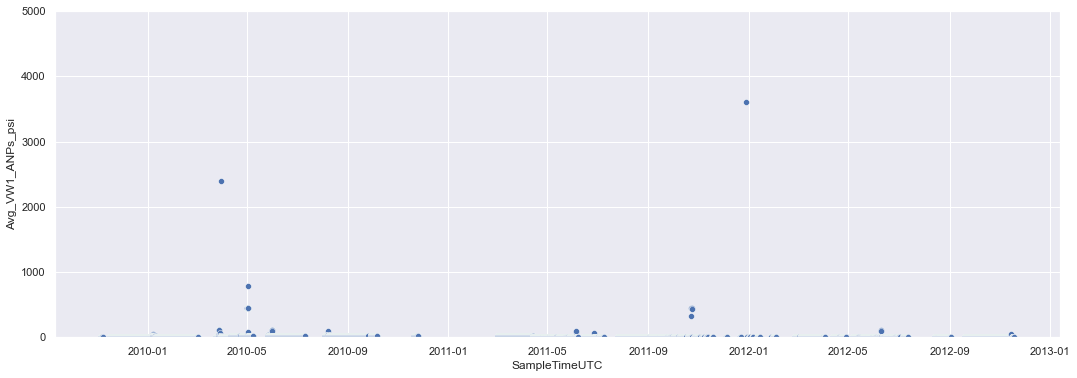

In [62]:
# set the figure size
sns.set(rc={'figure.figsize':(18, 6)})
# create a scatter plot with dots
sns.scatterplot(data=dftrain, x= dftrain.index, y='Avg_VW1_ANPs_psi')
# set the y-axis limit
plt.ylim(0, 5000)
# show the plot
plt.show()

In [63]:
# drop observation well annulkus pressure 
dftrain = dftrain.drop(columns='Avg_VW1_ANPs_psi')

In [64]:
dftrain.shape

(18401, 33)

C:\Users\vasan\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


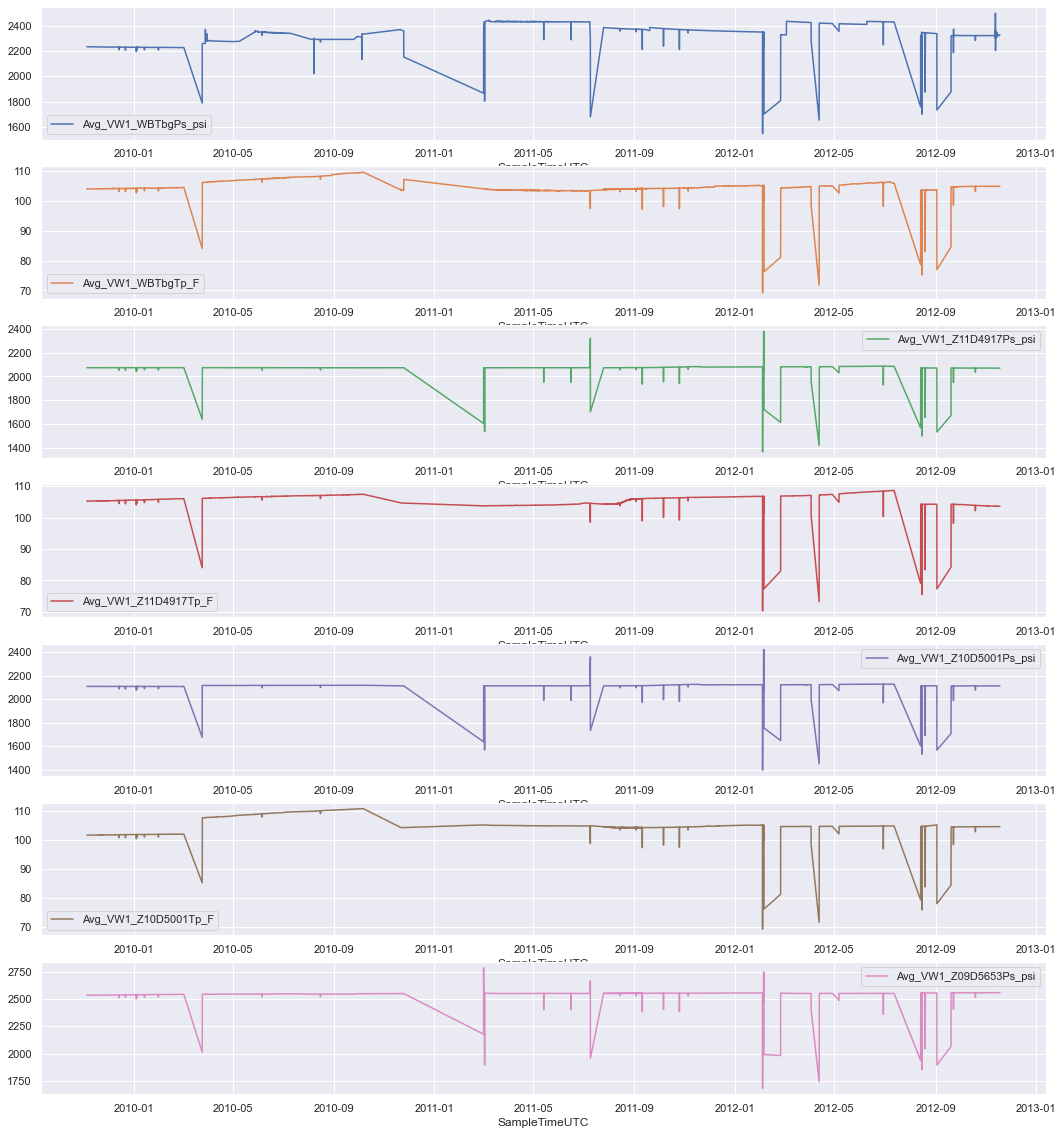

In [65]:
# create a plot with increased size
fig, ax = plt.subplots(figsize=(18, 20))
dftrain.iloc[:, 6:13].plot(ax=ax, subplots=True)


# show the plot
plt.show()

C:\Users\vasan\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


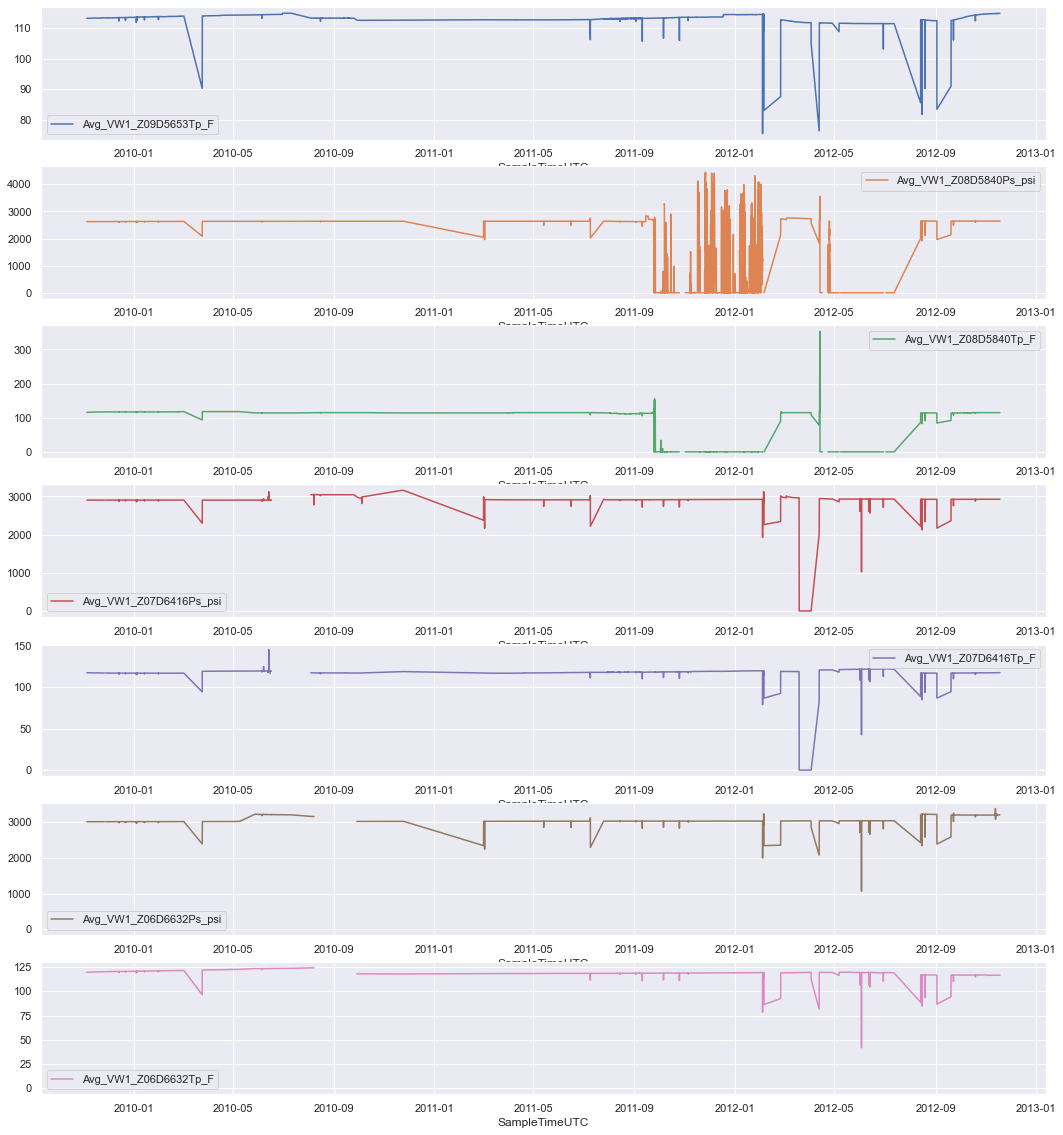

In [66]:
# create a plot with increased size
fig, ax = plt.subplots(figsize=(18, 20))
dftrain.iloc[:, 13:20].plot(ax=ax, subplots=True)


# show the plot
plt.show()

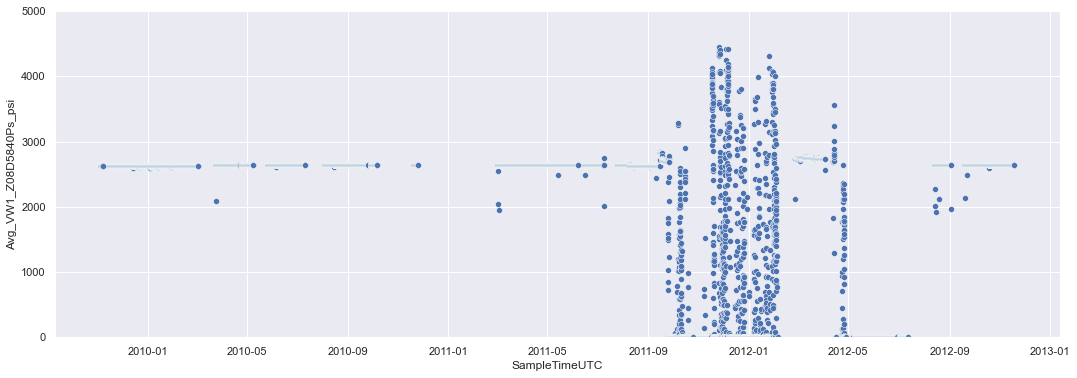

In [67]:
# set the figure size
sns.set(rc={'figure.figsize':(18, 6)})
# create a scatter plot with dots
sns.scatterplot(data=dftrain, x= dftrain.index, y='Avg_VW1_Z08D5840Ps_psi')
# set the y-axis limit
plt.ylim(0, 5000)
# show the plot
plt.show()

##Avg_VW1_Z08D5840Tp_F

In [68]:
# drop rows with values greater than 3000 in column 'Avg_VW1_Z08D5840Ps_psi'
dftrain = dftrain[dftrain['Avg_VW1_Z08D5840Ps_psi'] <= 3000]

# drop rows with values lesser than 1900 in column 'Avg_VW1_Z08D5840Ps_psi'
dftrain = dftrain[dftrain['Avg_VW1_Z08D5840Ps_psi'] >= 1900]

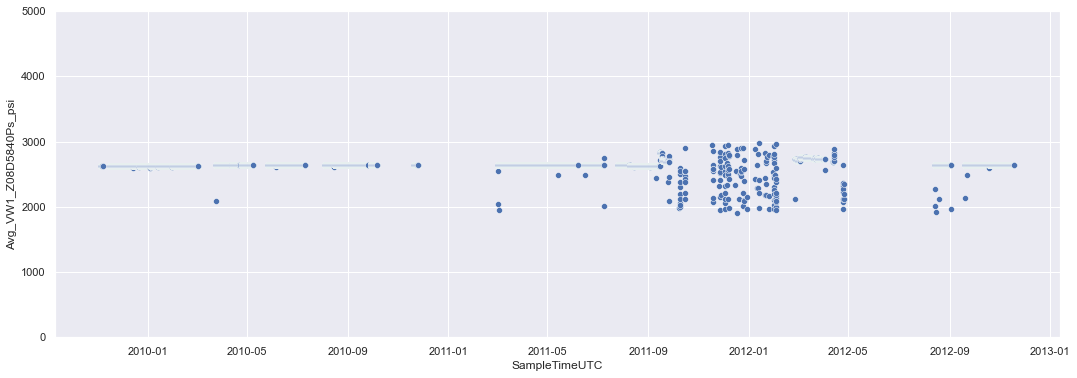

In [69]:
# set the figure size
sns.set(rc={'figure.figsize':(18, 6)})
# create a scatter plot with dots
sns.scatterplot(data=dftrain, x= dftrain.index, y='Avg_VW1_Z08D5840Ps_psi')
# set the y-axis limit
plt.ylim(0, 5000)
# show the plot
plt.show()

##Avg_VW1_Z08D5840Tp_F

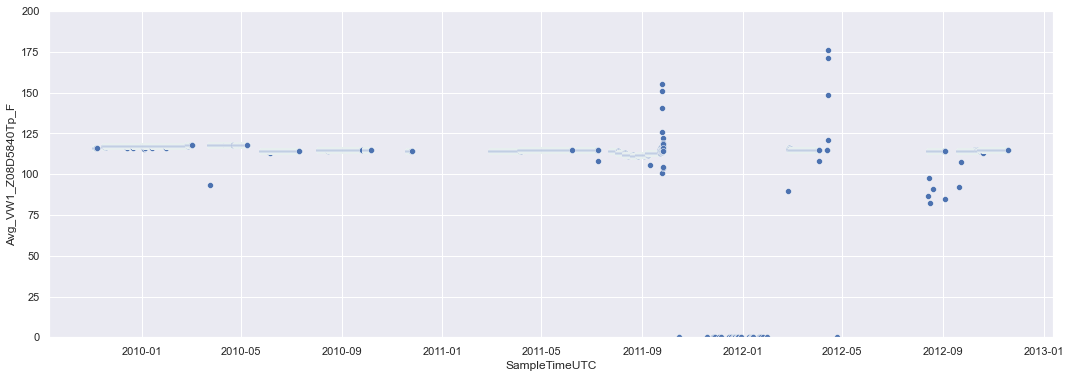

In [70]:
# set the figure size
sns.set(rc={'figure.figsize':(18, 6)})
# create a scatter plot with dots
sns.scatterplot(data=dftrain, x= dftrain.index, y='Avg_VW1_Z08D5840Tp_F')
# set the y-axis limit
plt.ylim(0, 200)
# show the plot
plt.show()

In [71]:
# drop rows with values =0 in column 'Avg_VW1_Z08D5840Tp_F'
dftrain = dftrain[dftrain['Avg_VW1_Z08D5840Tp_F'] != 0]

# drop rows with values above 125 in column 'Avg_VW1_Z08D5840Tp_F'
dftrain = dftrain[dftrain['Avg_VW1_Z08D5840Tp_F'] <= 125]

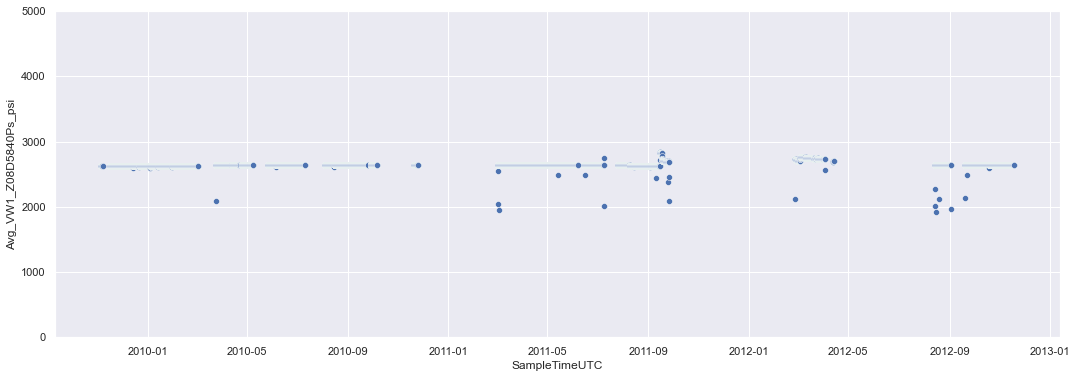

In [72]:
# set the figure size
sns.set(rc={'figure.figsize':(18, 6)})
# create a scatter plot with dots
sns.scatterplot(data=dftrain, x= dftrain.index, y='Avg_VW1_Z08D5840Ps_psi')
# set the y-axis limit
plt.ylim(0, 5000)
# show the plot
plt.show()

In [73]:
dftrain.shape

(13280, 33)

C:\Users\vasan\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


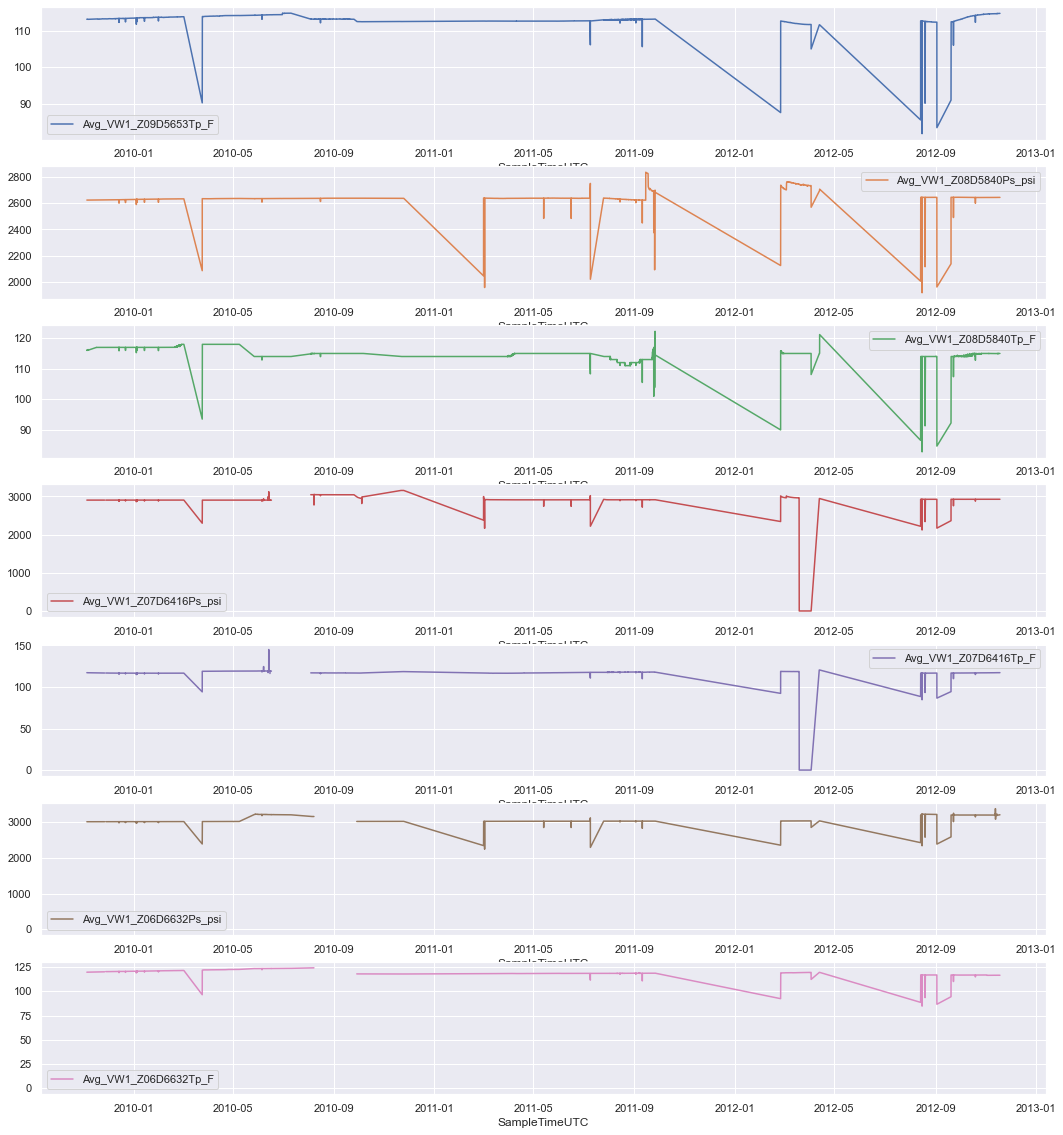

In [74]:
# create a plot with increased size
fig, ax = plt.subplots(figsize=(18, 20))
dftrain.iloc[:, 13:20].plot(ax=ax, subplots=True)


# show the plot
plt.show()

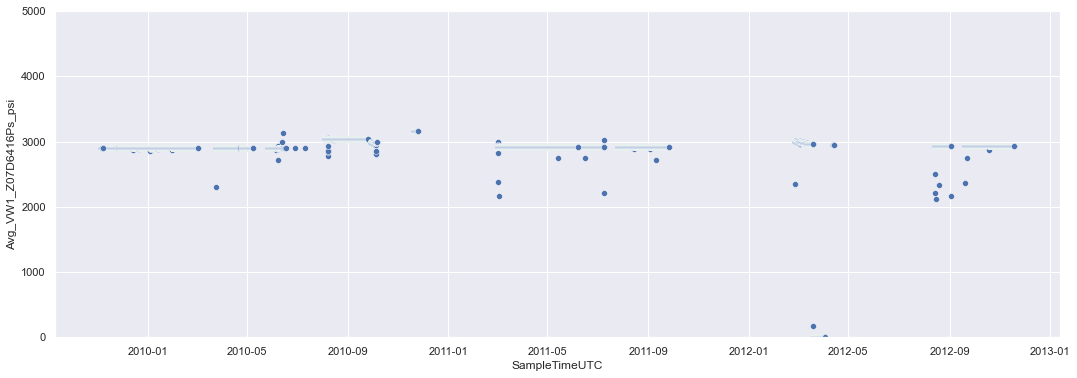

In [75]:
# set the figure size
sns.set(rc={'figure.figsize':(18, 6)})
# create a scatter plot with dots
sns.scatterplot(data=dftrain, x= dftrain.index, y='Avg_VW1_Z07D6416Ps_psi')
# set the y-axis limit
plt.ylim(0, 5000)
# show the plot
plt.show()

In [76]:
# drop rows with values =0 in column 'Avg_VW1_Z07D6416Ps_psi'
dftrain = dftrain[dftrain['Avg_VW1_Z07D6416Ps_psi'] >= 2000]
# drop rows with values =0 in column 'Avg_VW1_Z07D6416Tp_F'
dftrain = dftrain[dftrain['Avg_VW1_Z07D6416Tp_F'] != 0]

In [77]:
dftrain = dftrain[dftrain['Avg_VW1_Z06D6632Tp_F'] != 0]
dftrain = dftrain[dftrain['Avg_VW1_Z06D6632Ps_psi'] != 0]

C:\Users\vasan\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


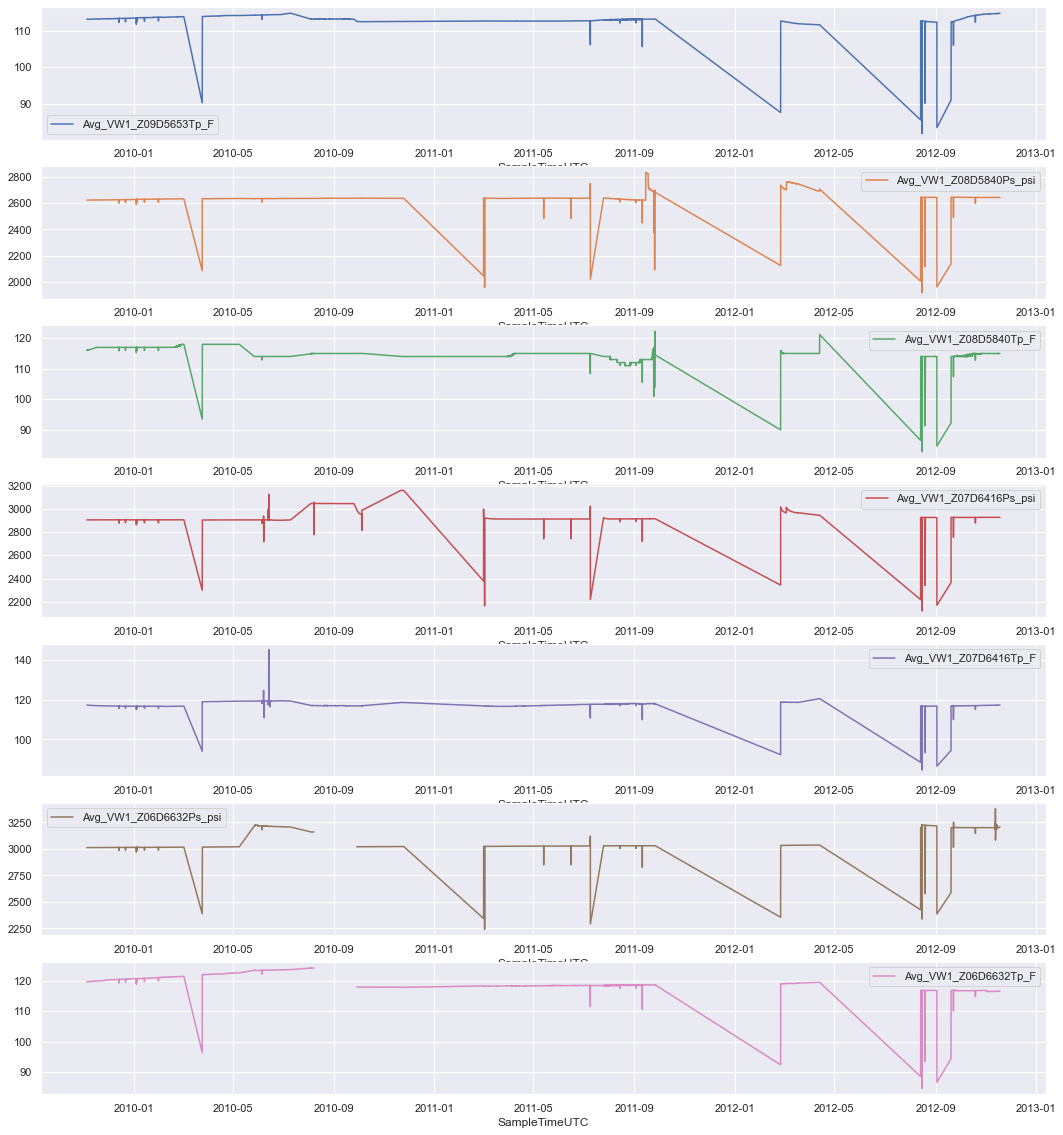

In [78]:
# create a plot with increased size
fig, ax = plt.subplots(figsize=(18, 20))
dftrain.iloc[:, 13:20].plot(ax=ax, subplots=True)


# show the plot
plt.show()

In [79]:
dftrain.shape

(12252, 33)

C:\Users\vasan\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


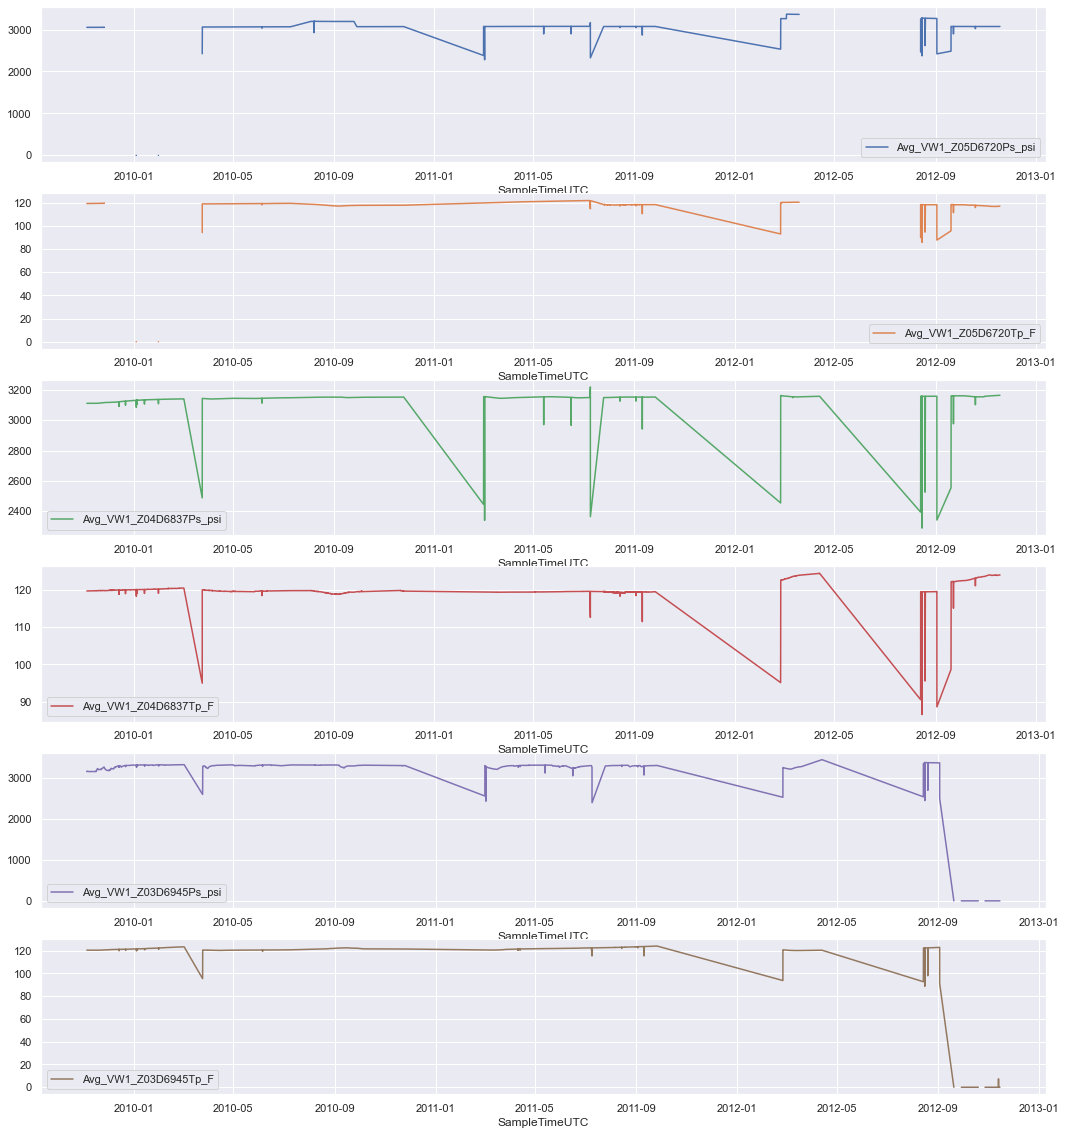

In [80]:
# create a plot with increased size
fig, ax = plt.subplots(figsize=(18, 20))
dftrain.iloc[:, 20:26].plot(ax=ax, subplots=True)


# show the plot
plt.show()

In [81]:
dftrain = dftrain[dftrain['Avg_VW1_Z05D6720Tp_F'] != 0]
dftrain = dftrain[dftrain['Avg_VW1_Z05D6720Ps_psi'] != 0]

In [82]:
dftrain.shape

(12238, 33)

In [83]:
dftrain = dftrain[dftrain['Avg_VW1_Z03D6945Tp_F'] != 0]
dftrain = dftrain[dftrain['Avg_VW1_Z03D6945Ps_psi'] != 0]

In [84]:
dftrain = dftrain[dftrain['Avg_VW1_Z03D6945Ps_psi'] >= 2000]

C:\Users\vasan\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


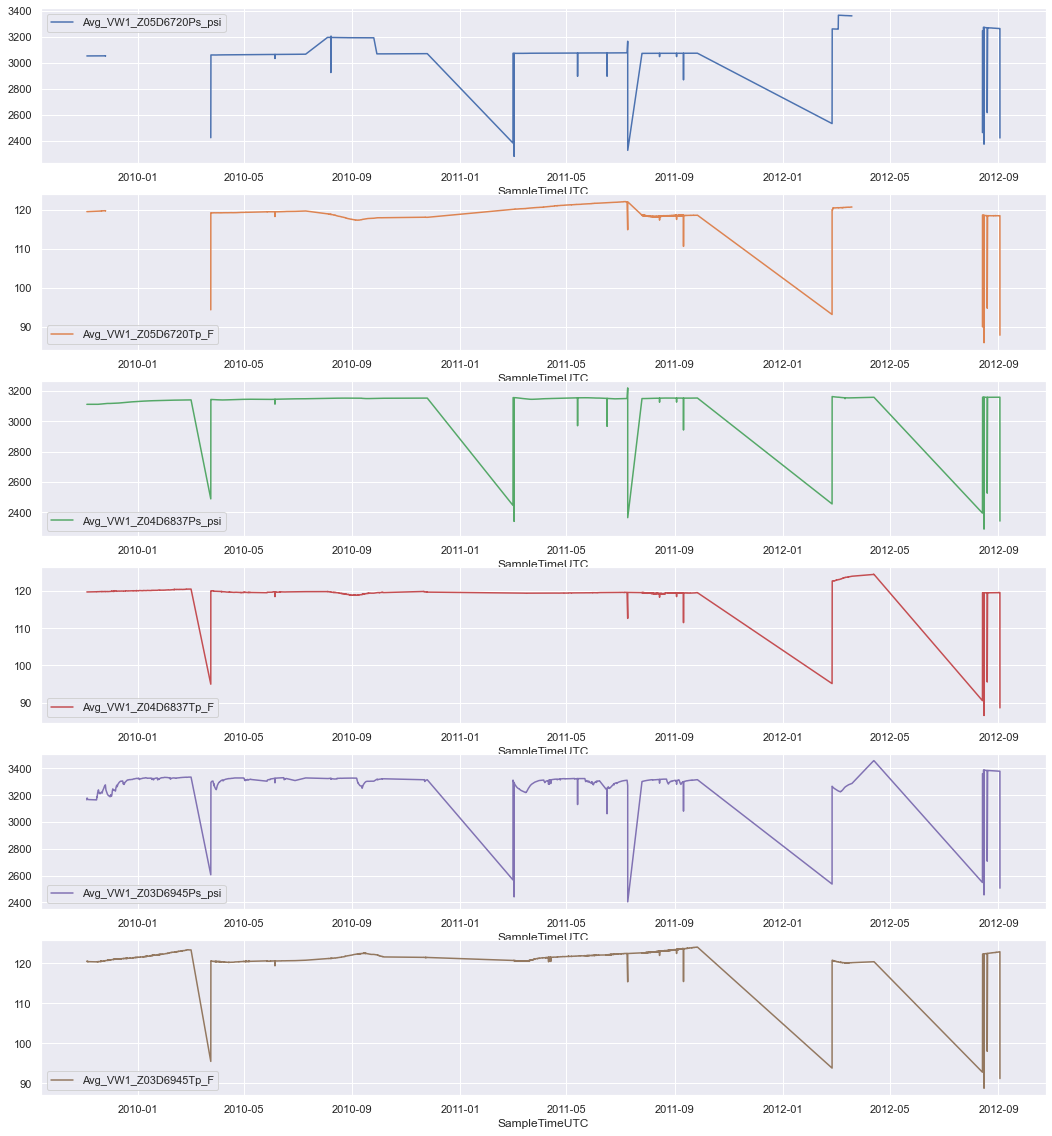

In [85]:
# create a plot with increased size
fig, ax = plt.subplots(figsize=(18, 20))
dftrain.iloc[:, 20:26].plot(ax=ax, subplots=True)


# show the plot
plt.show()

In [86]:
dftrain.shape

(10831, 33)

C:\Users\vasan\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


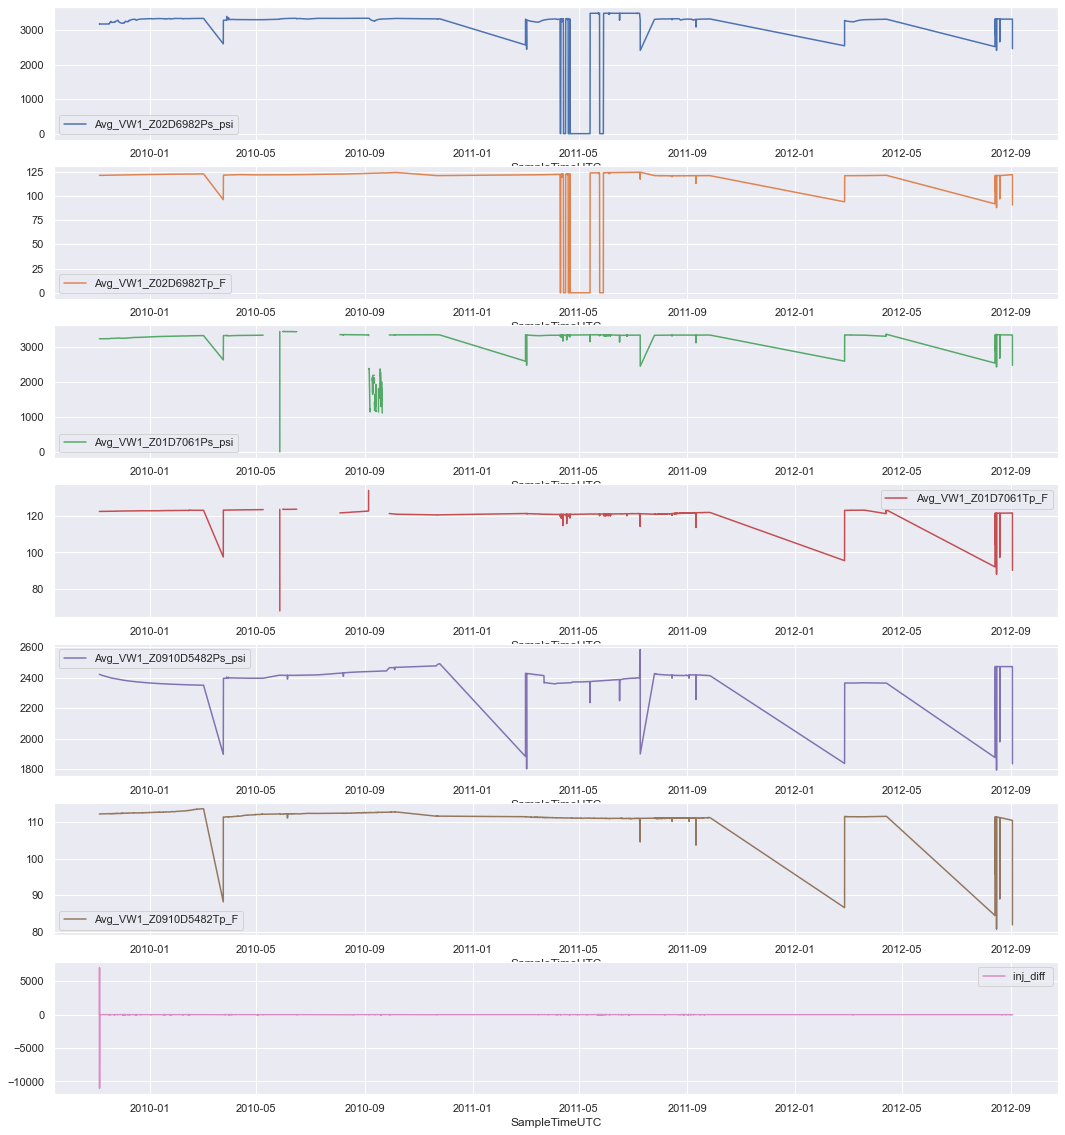

In [87]:
# create a plot with increased size
fig, ax = plt.subplots(figsize=(18, 20))
dftrain.iloc[:, 26:33].plot(ax=ax, subplots=True)


# show the plot
plt.show()

In [88]:
dftrain = dftrain[dftrain['Avg_VW1_Z02D6982Tp_F'] != 0]
dftrain = dftrain[dftrain['Avg_VW1_Z02D6982Ps_psi'] >= 2000]

In [89]:
dftrain = dftrain[dftrain['Avg_VW1_Z01D7061Tp_F'] != 0]
dftrain = dftrain[dftrain['Avg_VW1_Z01D7061Ps_psi'] >= 2200]

C:\Users\vasan\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


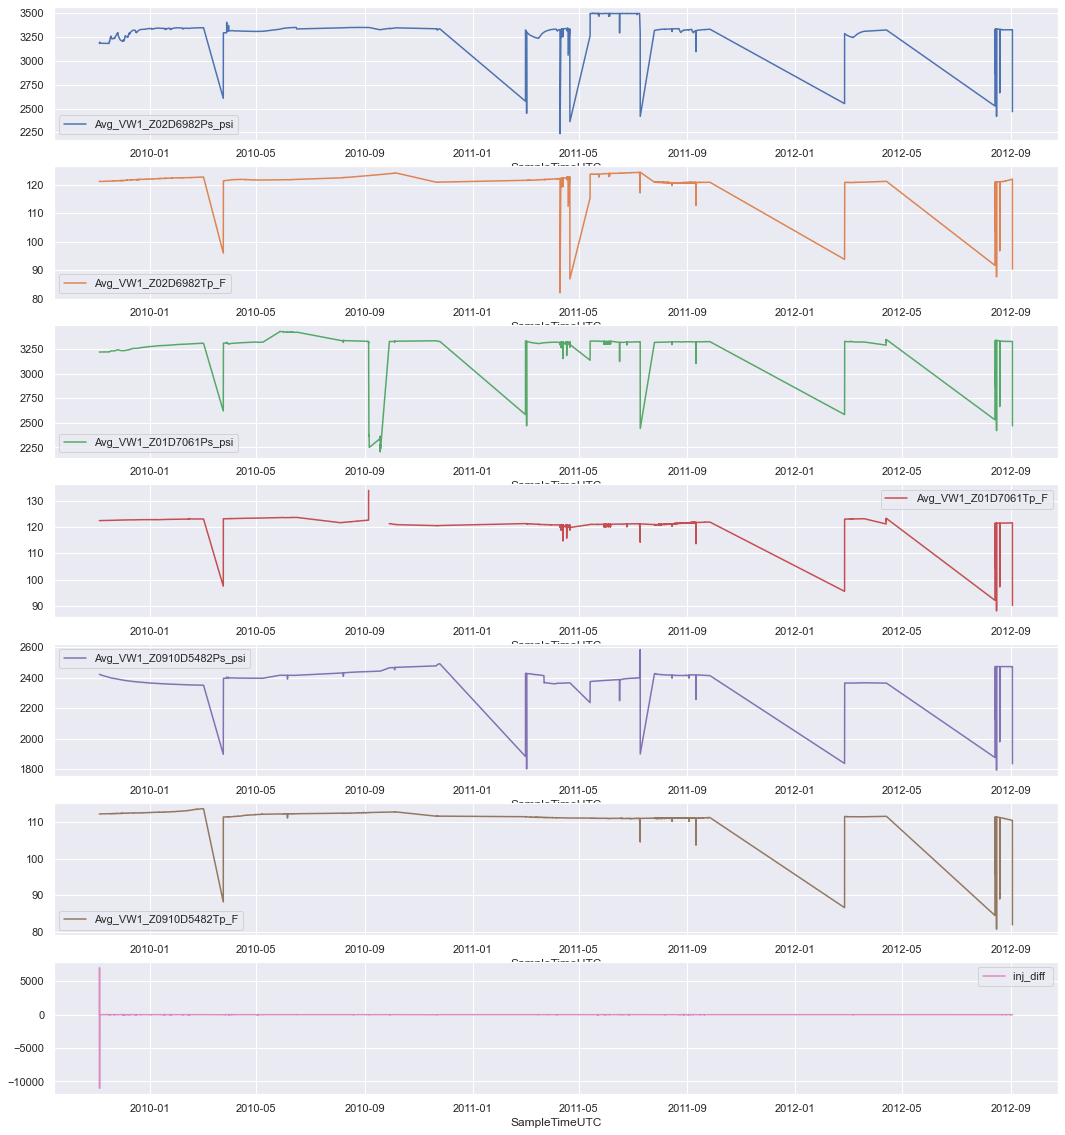

In [90]:
# create a plot with increased size
fig, ax = plt.subplots(figsize=(18, 20))
dftrain.iloc[:, 26:33].plot(ax=ax, subplots=True)


# show the plot
plt.show()

In [91]:
dftrain.shape

(9483, 33)

In [124]:
dftrain = dftrain[dftrain['inj_diff '] <= 2000]
dftrain = dftrain[dftrain['inj_diff '] >= -2000]

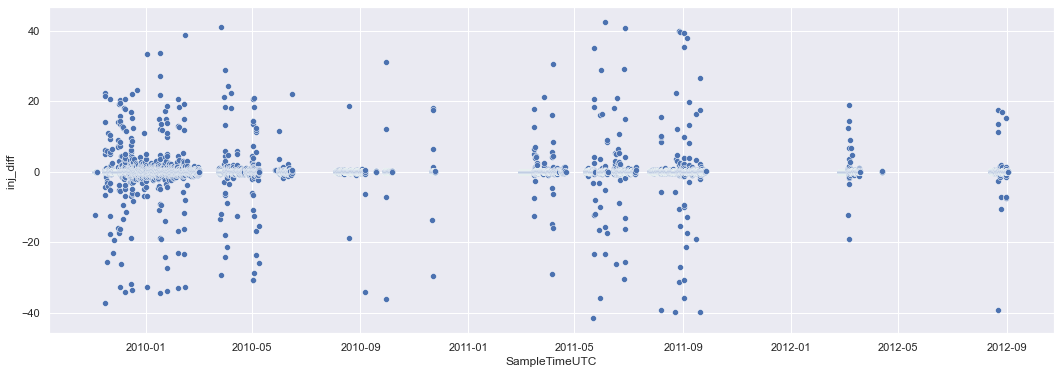

In [126]:
# set the figure size
sns.set(rc={'figure.figsize':(18, 6)})
# create a scatter plot with dots
sns.scatterplot(data=dftrain, x= dftrain.index, y='inj_diff ')
# set the y-axis limit
#plt.ylim(-50, 50)
# show the plot
plt.show()

In [127]:
df = dftrain.reset_index()

In [129]:
dftrain.shape

(9480, 33)

In [128]:
dftrain.dtypes

Avg_PLT_CO2VentRate_TPH     float64
Avg_CCS1_WHCO2InjPs_psi     float64
Avg_CCS1_WHCO2InjTp_F       float64
Avg_CCS1_ANPs_psi           float64
Avg_CCS1_DH6325Ps_psi       float64
Avg_CCS1_DH6325Tp_F         float64
Avg_VW1_WBTbgPs_psi         float64
Avg_VW1_WBTbgTp_F           float64
Avg_VW1_Z11D4917Ps_psi      float64
Avg_VW1_Z11D4917Tp_F        float64
Avg_VW1_Z10D5001Ps_psi      float64
Avg_VW1_Z10D5001Tp_F        float64
Avg_VW1_Z09D5653Ps_psi      float64
Avg_VW1_Z09D5653Tp_F        float64
Avg_VW1_Z08D5840Ps_psi      float64
Avg_VW1_Z08D5840Tp_F        float64
Avg_VW1_Z07D6416Ps_psi      float64
Avg_VW1_Z07D6416Tp_F        float64
Avg_VW1_Z06D6632Ps_psi      float64
Avg_VW1_Z06D6632Tp_F        float64
Avg_VW1_Z05D6720Ps_psi      float64
Avg_VW1_Z05D6720Tp_F        float64
Avg_VW1_Z04D6837Ps_psi      float64
Avg_VW1_Z04D6837Tp_F        float64
Avg_VW1_Z03D6945Ps_psi      float64
Avg_VW1_Z03D6945Tp_F        float64
Avg_VW1_Z02D6982Ps_psi      float64
Avg_VW1_Z02D6982Tp_F        

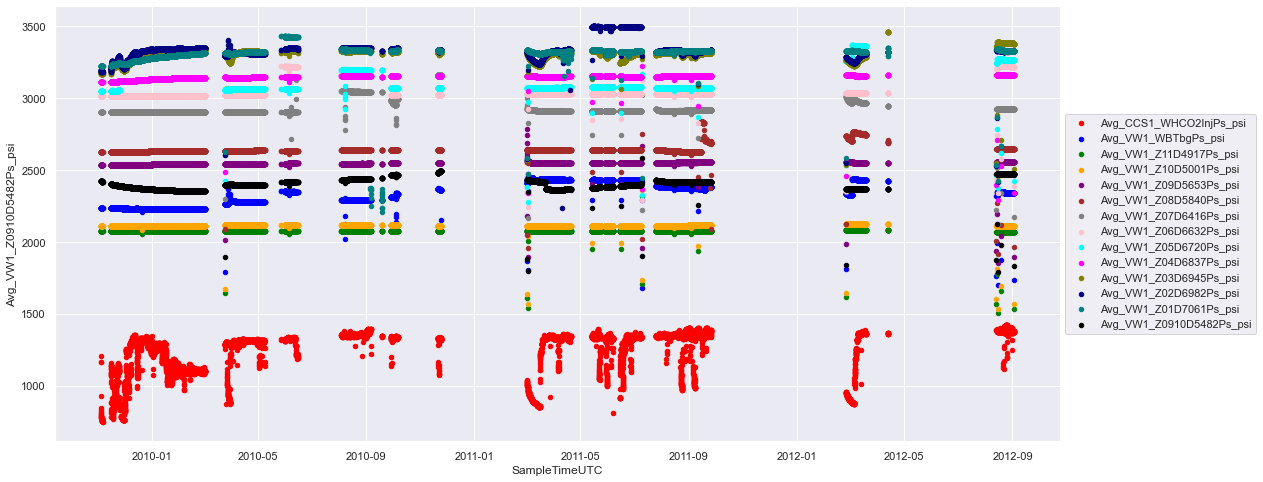

In [130]:
fig, ax = plt.subplots(figsize=(18, 8))

y_columns = ['Avg_CCS1_WHCO2InjPs_psi', 'Avg_VW1_WBTbgPs_psi', 'Avg_VW1_Z11D4917Ps_psi', 'Avg_VW1_Z10D5001Ps_psi', 'Avg_VW1_Z09D5653Ps_psi', 'Avg_VW1_Z08D5840Ps_psi', 'Avg_VW1_Z07D6416Ps_psi', 'Avg_VW1_Z06D6632Ps_psi', 'Avg_VW1_Z05D6720Ps_psi', 'Avg_VW1_Z04D6837Ps_psi', 'Avg_VW1_Z03D6945Ps_psi', 'Avg_VW1_Z02D6982Ps_psi', 'Avg_VW1_Z01D7061Ps_psi', 'Avg_VW1_Z0910D5482Ps_psi']

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'gray', 'pink', 'cyan', 'magenta', 'olive', 'navy', 'teal', 'black']

for i, y_col in enumerate(y_columns):
    df.plot(kind='scatter', x='SampleTimeUTC', y=y_col, ax=ax, color=colors[i], label=y_col)
    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

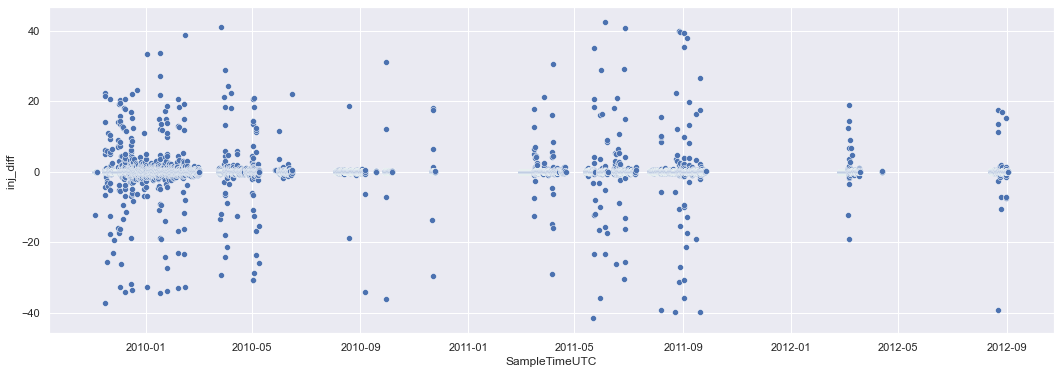

In [131]:
# set the figure size
sns.set(rc={'figure.figsize':(18, 6)})
# create a scatter plot with dots
sns.scatterplot(data=dftrain, x= dftrain.index, y='inj_diff ')
# set the y-axis limit
#plt.ylim(-50, 50)
# show the plot
plt.show()

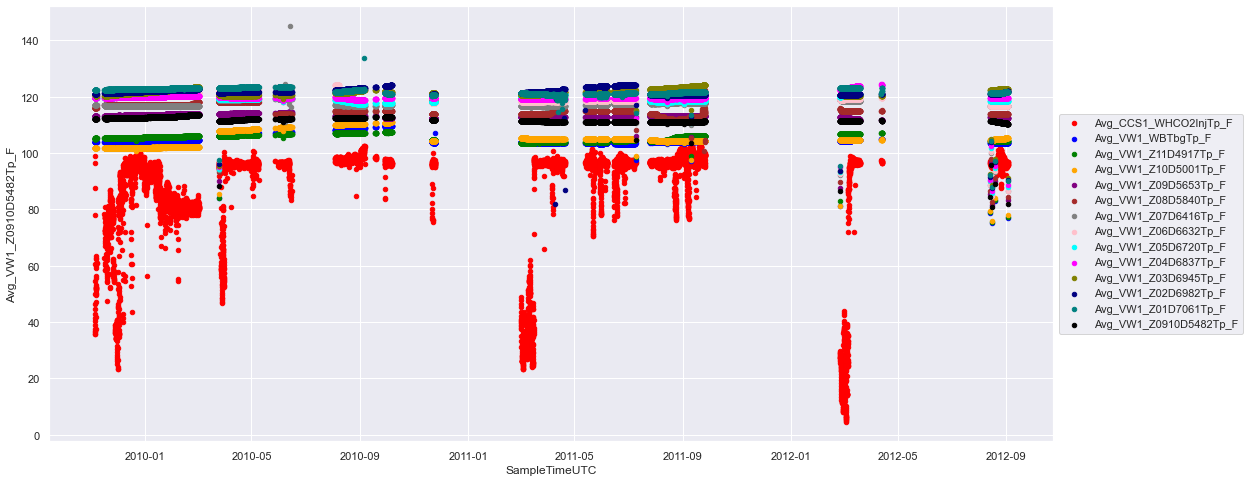

In [132]:
fig, ax = plt.subplots(figsize=(18, 8))

y_columns = ['Avg_CCS1_WHCO2InjTp_F', 'Avg_VW1_WBTbgTp_F', 'Avg_VW1_Z11D4917Tp_F', 'Avg_VW1_Z10D5001Tp_F', 'Avg_VW1_Z09D5653Tp_F', 'Avg_VW1_Z08D5840Tp_F', 'Avg_VW1_Z07D6416Tp_F', 'Avg_VW1_Z06D6632Tp_F', 'Avg_VW1_Z05D6720Tp_F', 'Avg_VW1_Z04D6837Tp_F', 'Avg_VW1_Z03D6945Tp_F', 'Avg_VW1_Z02D6982Tp_F', 'Avg_VW1_Z01D7061Tp_F', 'Avg_VW1_Z0910D5482Tp_F']

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'gray', 'pink', 'cyan', 'magenta', 'olive', 'navy', 'teal', 'black']

for i, y_col in enumerate(y_columns):
    df.plot(kind='scatter', x='SampleTimeUTC', y=y_col, ax=ax, color=colors[i], label=y_col)
    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))